In [1]:
import os
import glob
import numpy as np
import pandas as pd
import pickle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.patches as mpatches
from shapely.geometry import Polygon, Point
from shapely import contains
from matplotlib.patches import Polygon as MplPolygon
import abfile

### **Subseting model variable for model validation by sub regions** ###

This notebook is for complimenting NERSC-HYCOM-CICE BGC validation tool on NERSC github repository:

[bgc.validation](https://github.com/nansencenter/NERSC-HYCOM-CICE/tree/bgc_validation_folder/bin/bgc.validation)

Main functions provided here are:

- Custom designing of model validation regions
- Creation of mask file compatible with `make_OM_regional_masks.py` -saved mask file
- Creation of mask file useful for generating Polygon data for each validation region

Note that the mask file generation depends on model grid coordinate. For hycom grid data, change location of `regional.grid.[a,b]` file by editing `DIR_CNFG` below.

**Step 1:** Define a set of sub-regions.

Sub-regions are defined by specifying corners on lat-lon coordinate on Python dictionary. Sample dictionary, `dict_region`, for ARC MFC model validation can be found below.

**Step 2:** Convert the Python dictionary to mask information.

Two options are provided on this notebook:

- Convert the dictionary to boolean mask data
- Convert the dictionary to 2D mask [0 or 1] data (as `make_OM_regional_masks.py`)

Note 2D mask should be created after boolean mask.

**Step 3:** Extract subset of model variable using mask data

Two options are provided on this notebook:

- Create masked model variable masked outside of target region using 2D mask
- Extract subset of model variable inside of target region using boolean mask

Note boolean mask extract 1D array from 2D array.

**Other useful operations:**

- Create new region by merging existing two regions
- Plot shape of sub-regions on a map
- Check region index number

In [2]:
#
# ARCMFC validation regions definition [2025.11.05 last updated]
#

# Python dictionary

dict_regions = {
    'BFFB': {  # Baffin Bay
        'lonr': [-78, -51, -51, -78],
        'latr': [68, 68, 81, 81],
        'long_name': 'Baffin Bay'
    },
    'LBRD': {  # Labrador Sea
        'lonr': [-64, -46, -46, -64],
        'latr': [55, 55, 68, 68],
        'long_name': 'Labrador Sea'
    },
    'KARA': {  # Kara Sea
        'lonr': [58, 100, 100, 58],
        'latr': [68, 68, 81, 81],
        'long_name': 'Kara Sea'
    },
    'BRTS': {  # Barents Sea
        'lonr': [16, 58, 58, 16],
        'latr': [68, 68, 81, 81],
        'long_name': 'Barents Sea'
    },
    'NRWS': {  # Norwegian Sea = LFTB + NRWB
        'lonr': [-10, 16, 16, 7, 7, -10],
        'latr': [62, 62, 81, 81, 73, 73],
        'long_name': 'Norwegian Sea'
    },
    'NRWB': {  # Norwegian Basin
        'lonr': [-10, 16, 16,-10],
        'latr': [ 62, 62, 68, 68],
        'long_name': 'Norwegian Basin'
    },
    'LFTB': {  # Lofoten Basin
        'lonr': [-10, 16, 16, 7, 7, -10],
        'latr': [68, 68, 81, 81, 73, 73],
        'long_name': 'Lofoten Basin'
    },
    'GSIS': {  # Greenland–Iceland Seas = GRLS + ICLS
        'lonr': [-37, -10, -10, 7, 7, -25, -25, -37],
        'latr': [66, 66, 73, 73, 81, 81, 73, 73],
        'long_name': 'Greenland–Iceland Seas'
    },
    'GRLS': {  # Greenland Sea
        'lonr': [-25,  7,  7,-25],
        'latr': [ 73, 73, 81, 81],
        'long_name': 'Greenland Sea'
    },
    'ICLS': {  # Iceland Sea
        'lonr': [-37,-10,-10,-37],
        'latr': [ 66, 66, 73, 73],
        'long_name': 'Iceland Sea'
    },
    'IBIB': {  # Irminger–Iceland Basins = IMGB + ICLB
        'lonr': [-46,-10,-10,-46],
        'latr': [ 55, 55, 66, 66],
        'long_name': 'Irminger–Iceland Basins'
    },
    'IMGB': {  # Irminge Basin
        'lonr': [-46,-28,-28,-46],
        'latr': [ 55, 55, 66, 66],
        'long_name': 'Irminger Basin'
    },
    'ICLB': {  # Iceland Basin
        'lonr': [-28,-10,-10,-28],
        'latr': [ 55, 55, 66, 66],
        'long_name': 'Iceland Basin'
    },
    'ENWS': {  # European North West Shelf
        'lonr': [-10, 10, 10, -10],
        'latr': [51, 51, 62, 62],
        'long_name': 'European North West Shelf'
    },
    'NASG': {  # North Atlantic Subpolar Gyre
        'lonr': [-50, -15, -15, 50],
        'latr': [50, 50, 58, 58],
        'long_name': 'North Atlantic Subpolar Gyre'
    },
    'CACH': {  # Canadian Archipelago
        'lonr': [-123, -78, -78, -123],
        'latr': [68, 68, 81, 81],
        'long_name': 'Canadian Archipelago'
    },
    'ERSB': {  # Eurasia Basin
        'lonr': [100, 100, 140, 140,-25,-25],
        'latr': [ 81,  78,  78,  89.9999, 89.9999, 81],
        'long_name': 'Eurasia Basin'
    },
    'ARSB': {  # Amerasia Basin
        'lonr': [140, 180, 180, 237, 237, 335, 335, 140],
        'latr': [ 78,  78,  76,  76,  81,  81,  89.9999,  89.9999],
        'long_name': 'Amerasia Basin'
    },
    'LPES': {  # Laptev-East Siberian Seas = LPTV + ESBR
        'lonr': [100,180,180,100],
        'latr': [ 68, 68, 78, 78],
        'long_name': 'Laptev-East Siberian Seas'
    },
    'LPTV': {  # Laptev Sea
        'lonr': [100,140,140,100],
        'latr': [ 68, 68, 78, 78],
        'long_name': 'Laptev Sea'
    },
    'ESBR': {  # East Siberian Sea
        'lonr': [140,180,180,140],
        'latr': [ 68, 68, 78, 78],
        'long_name': 'East Siberian Sea'
    },
    'CHBF': {  # Chukchi–Beaufort Seas = CHKC + BFRT
        'lonr': [-180,-158,-158,-123,-123,-180],
        'latr': [  66,  66,  68,  68,  76,  76],
        'long_name': 'Chukchi–Beaufort Seas'
    },
    'CHKC': {  # Chukchi Sea
        'lonr': [-180,-158,-158,-180],
        'latr': [  66,  66,  76,  76],
        'long_name': 'Chukchi Sea'
    },
    'BFRT': {  # Beaufort Sea
        'lonr': [-158,-123,-123,-158],
        'latr': [  68,  68,  76,  76],
        'long_name': 'Beaufort Sea'
    },
    'BRGS': {  # Bering Shelf
        'lonr': [-180, -158, -158, -180],
        'latr': [56, 56, 66, 66],
        'long_name': 'Bering Shelf'
    },
    'BLTS': {  # Baltic Sea
        'lonr': [10, 31, 31, 16, 16, 10],
        'latr': [53, 53, 67, 67, 60, 60],
        'long_name': 'Baltic Sea'
    },
    'HDBC': {  # Hudson Bay Complex
        'lonr': [-96, -64, -64, -96],
        'latr': [51, 51, 68, 68],
        'long_name': 'Hudson Bay Complex'
    },
}

# Save region definition files

with open('./validation_regions_ARCMFC.pckl', 'wb') as f:
    pickle.dump(dict_regions, f)

In [3]:
def corner_to_polygon_highres(latr,lonr):
    res = 200 # number of sections between 2 polygon corners

    # detect section between polygon corners 
    
    sub_lonr = []
    sub_latr = []

    for i in range(len(lonr)):
        j = (i + 1) % len(lonr)  # next index, wrap at end
        sub_lonr.append([lonr[i], lonr[j]])
        sub_latr.append([latr[i], latr[j]])

    # Create high-resolution polygon data along lat-lon coordinate

    lonr_highres = []
    latr_highres = []

    for k in range(len(sub_lonr)):
        if sub_lonr[k][0] == sub_lonr[k][1]:
            sub_lonr_highres = np.ones(res)*sub_lonr[k][0]
        else:
            sub_lonr_highres = np.linspace(sub_lonr[k][0],sub_lonr[k][1],res)

        if sub_latr[k][0] == sub_latr[k][1]:
            sub_latr_highres = np.ones(res)*sub_latr[k][0]
        else:
            sub_latr_highres = np.linspace(sub_latr[k][0],sub_latr[k][1],res)

        lonr_highres.extend(sub_lonr_highres[:-1])
        latr_highres.extend(sub_latr_highres[:-1])

    polygon = Polygon(list(zip(lonr_highres, latr_highres)))
    
    return polygon

In [4]:
def polygon_from_dict(name, dict_regions):

    latr = dict_regions[name]['latr']
    lonr = dict_regions[name]['lonr']
    long_name = dict_regions[name]['long_name']

    label_latr = 0.5*(max(latr)+min(latr)) 
    label_lonr = 0.5*(max(lonr)+min(lonr)) 
    label_coord = [label_latr, label_lonr]
    
    polygon = corner_to_polygon_highres(latr,lonr) # increase resolution
    
    return polygon,label_coord,long_name

In [5]:
def polygon_merger(name_1,name_2,dict_regions):
    latr_1 = dict_regions[name_1]['latr']
    lonr_1 = dict_regions[name_1]['lonr']
    polygon_1 = Polygon(list(zip(lonr_1, latr_1)))
    
    latr_2 = dict_regions[name_2]['latr']
    lonr_2 = dict_regions[name_2]['lonr']
    polygon_2 = Polygon(list(zip(lonr_2, latr_2)))
    
    # Merge polygons
    polygon_new = polygon_1.union(polygon_2)

    # Extract coordinates back
    coords = list(polygon_new.exterior.coords)

    # Split into lon and lat
    lonr_out, latr_out = zip(*coords)

    # Convert back to lists (optional)
    lonr_new = list(lonr_out[:-1])
    latr_new = list(latr_out[:-1])

    return latr_new,lonr_new

In [6]:
def plot_regions(list_polyname,list_extent,projection,dict_regions,regions_title,loc_data=None,var_data=None,vmin=None,vmax=None):
    figsize=(8,8)
    crs_latlon = ccrs.PlateCarree()
    ig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': projection})
    ax.set_extent(list_extent, crs=crs_latlon)

    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black',linewidth=0.5)
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='palegoldenrod')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue',alpha=0.3)

    if loc_data is not None:
        lonf = loc_data[0]
        latf = loc_data[1]

        if var_data is not None:
            if vmin is not None:
                sc = ax.scatter(lonf, latf, s=1.0, marker='o', c=var_data, cmap='viridis', transform=crs_latlon, label='Data Location',vmin=vmin,vmax=vmax)
            else:
                sc = ax.scatter(lonf, latf, s=1.0, marker='o', c=var_data, cmap='viridis', transform=crs_latlon, label='Data Location')
            plt.colorbar(sc, shrink=0.6)
        else:
            ax.scatter(lonf, latf, color='grey', s=0.5, marker='o', transform=crs_latlon, label='Data Location')
    
    legend_handles = []

    for name in list_polyname:
        polygon, label_coord, long_name = polygon_from_dict(name,dict_regions)
        patch = MplPolygon(polygon.exterior.coords,edgecolor='white',linewidth=2,facecolor='none',alpha=1.0,transform=ccrs.PlateCarree(),zorder=10)
        ax.add_patch(patch)
        patch = MplPolygon(polygon.exterior.coords,edgecolor='none',linewidth=2,facecolor='grey',alpha=0.2,transform=ccrs.PlateCarree(),zorder=10)
        ax.add_patch(patch)
        lat, lon = label_coord
        label_name = f"{name}"
        txt=ax.text(lon,lat,label_name,transform=crs_latlon,color='black',fontsize=12,ha='center',va='center', fontfamily='monospace',zorder=11)
        txt.set_path_effects([path_effects.Stroke(linewidth=3, foreground='white'),path_effects.Normal()])

        # create a dummy patch for legend
        label_text = f"{name}: {long_name}"
        handle = mpatches.Patch(color='grey', alpha=0.3, label=label_text)
        legend_handles.append(handle)

    if var_data is None:
        legend = ax.legend(handles=legend_handles, title="Regions", loc='center left', bbox_to_anchor=(1.05, 0.5),handlelength=1, handleheight=1, prop={'family': 'monospace', 'size': 12})
        plt.setp(legend.get_title(), fontfamily='monospace', fontsize=12)
    ax.set_title(f"{regions_title}")

    plt.show()

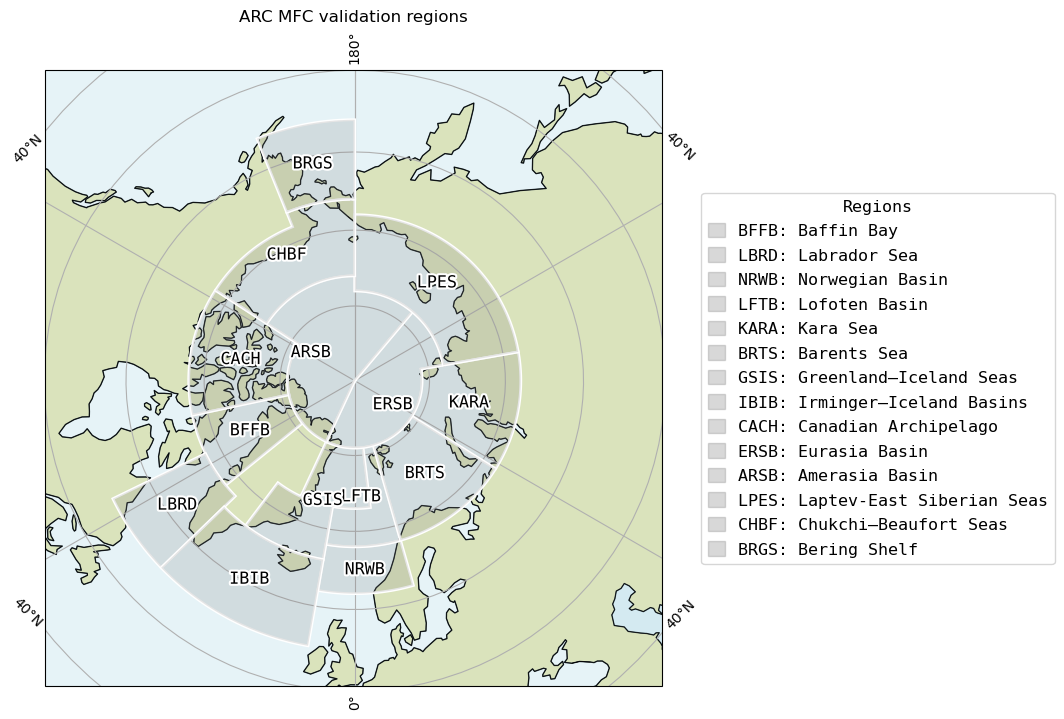

In [7]:
#----------------------------------------------------
# Sample Use Case: 
#    
#      plot subset of regions for QUID validation
#
#----------------------------------------------------

title = f"ARC MFC validation regions"

# load region definition files

with open('./validation_regions_ARCMFC.pckl', 'rb') as f:
    dict_regions = pickle.load(f)

# plot regions

list_polyname = ['BFFB','LBRD','NRWB','LFTB','KARA','BRTS','GSIS','IBIB','CACH','ERSB','ARSB','LPES','CHBF','BRGS']
list_extent = (-180, 180, 50, 90)
projection = ccrs.NorthPolarStereo()
regions_title = f"{title}"

plot_regions(list_polyname,list_extent,projection,dict_regions,regions_title)

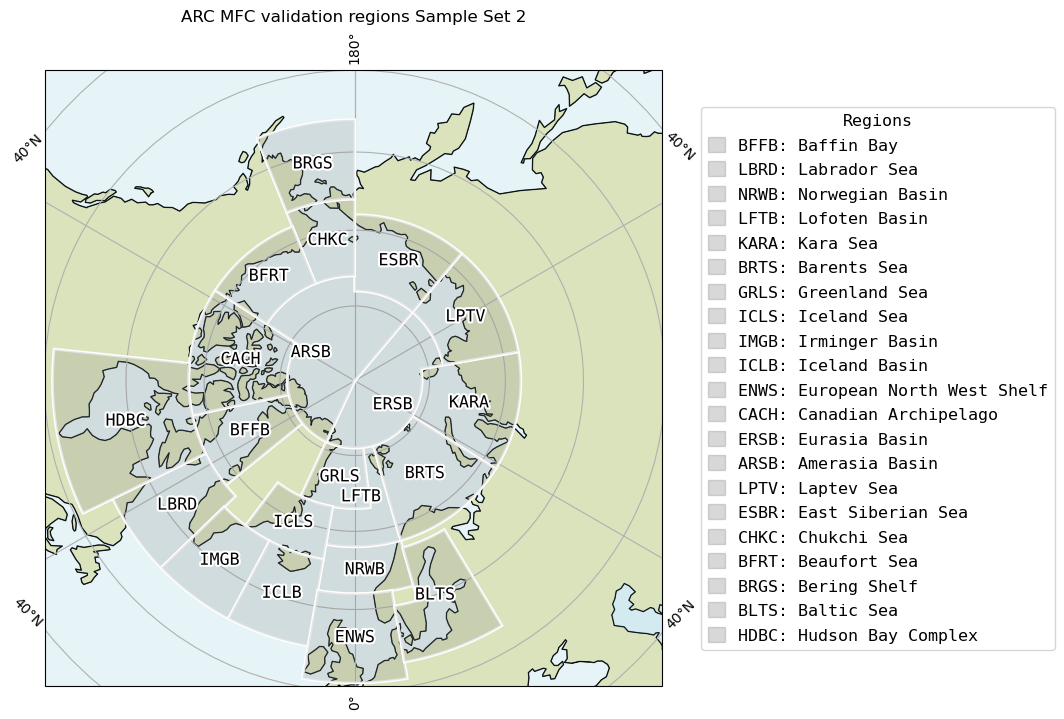

In [8]:
#----------------------------------------------------
# Sample Use Case: 
#    
#      plot subset of regions: sample set 2
#
#----------------------------------------------------

# load region definition files

with open('./validation_regions_ARCMFC.pckl', 'rb') as f:
    dict_regions = pickle.load(f)

# plot regions

list_polyname = ['BFFB','LBRD','NRWB','LFTB','KARA','BRTS','GRLS','ICLS','IMGB','ICLB','ENWS','CACH','ERSB','ARSB','LPTV','ESBR','CHKC','BFRT','BRGS','BLTS','HDBC']
list_extent = (-180, 180, 50, 90)
projection = ccrs.NorthPolarStereo()
regions_title = f"{title} Sample Set 2"

plot_regions(list_polyname,list_extent,projection,dict_regions,regions_title)

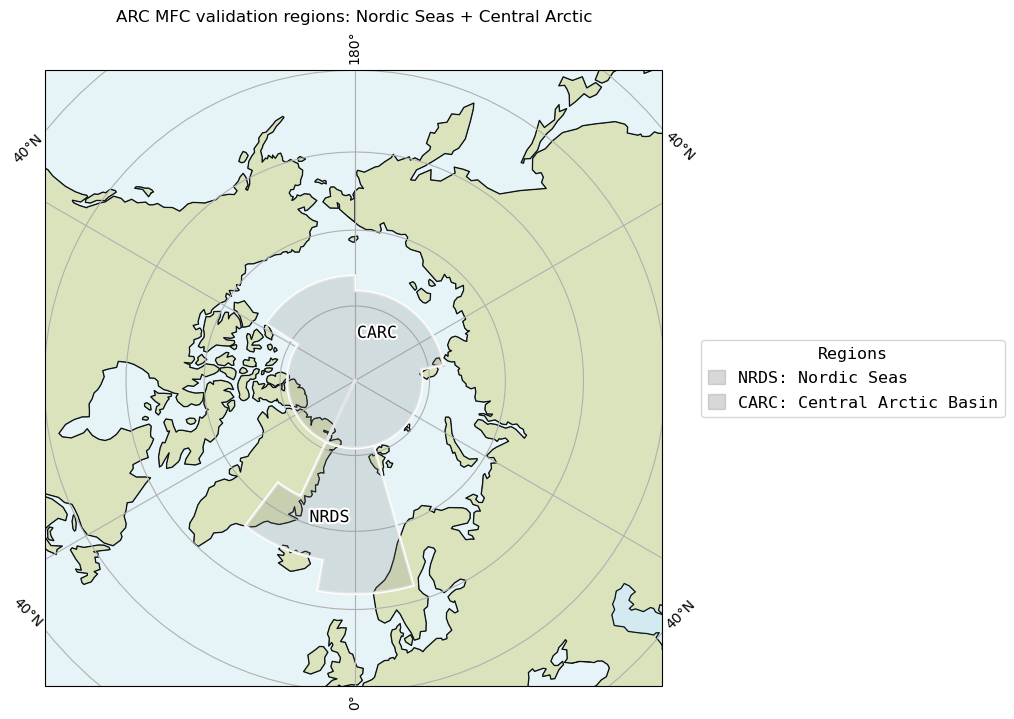

In [9]:
#----------------------------------------------------
# Sample Use Case: 
#    
#    Create new region by merging existing 2 regions
#
#----------------------------------------------------

# load region definition files

with open('./validation_regions_ARCMFC.pckl', 'rb') as f:
    dict_regions = pickle.load(f)

#-- create new region: Nordic Seas

latr,lonr = polygon_merger('GSIS','NRWS', dict_regions) # merge existing 2 regions

# register new region to existing dictionary

dict_regions['NRDS'] = { 
    'lonr': lonr,
    'latr': latr,
    'long_name': 'Nordic Seas'
}

#-- create new region: Central Arctic Basin

latr,lonr = polygon_merger('ARSB','ERSB', dict_regions) # merge 2 regions

# register new region to existing dictionary

dict_regions['CARC'] = { 
    'lonr': lonr,
    'latr': latr,
    'long_name': 'Central Arctic Basin'
}

#-- update region definition file

# Save region definition files

with open('./validation_regions_ARCMFC.pckl', 'wb') as f:
    pickle.dump(dict_regions, f)

#-- check new regions

# load updated region definition files

with open('./validation_regions_ARCMFC.pckl', 'rb') as f:
    dict_regions = pickle.load(f)

list_polyname = ['NRDS','CARC']
list_extent = (-180, 180, 50, 90)
projection = ccrs.NorthPolarStereo()
regions_title = f"{title}: Nordic Seas + Central Arctic"

plot_regions(list_polyname,list_extent,projection,dict_regions,regions_title)

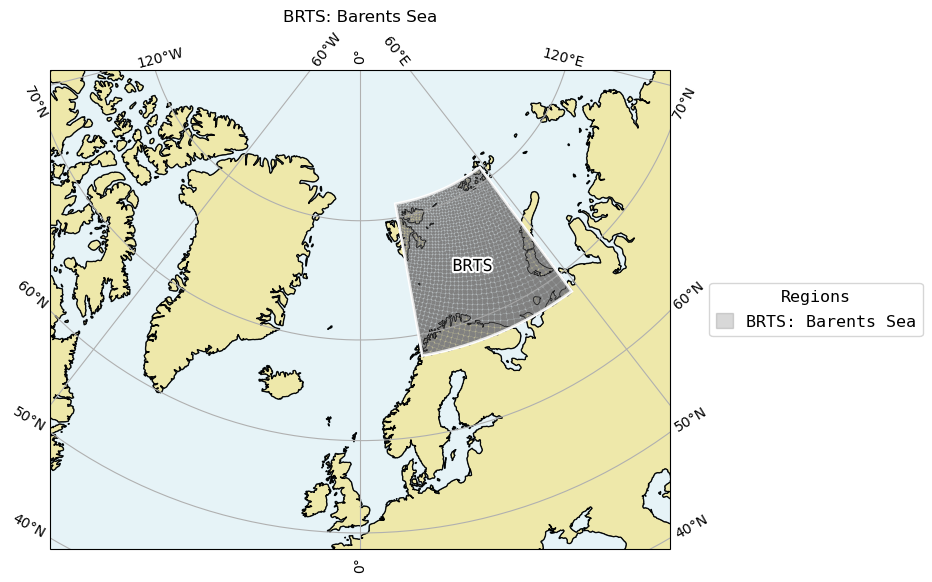

In [10]:
#-----------------------------------------------------------------
# Sample Use Case:
#
#   Extract model grid inside of target region
#
#      input: validation_regions_ARCMFC.pckl
#
#-----------------------------------------------------------------

polyname = 'BRTS' # target region name

#-- load region definition files

with open('./validation_regions_ARCMFC.pckl', 'rb') as f:
    dict_regions = pickle.load(f)

#-- define TP2 grid file name

region = 'TP2a0.10'
DIR_CNFG=f"/root/projects/bioran_v2/NERSC-HYCOM-CICE_BIORANv2/{region}/topo" # where to find "regional.grid"
grid = f"{DIR_CNFG}/regional.grid"

#-- load TP2 grid data

abgrid = abfile.ABFileGrid(grid,"r")
plon=abgrid.read_field("plon")
plat=abgrid.read_field("plat")

#-- extract polygon information from dictionary

list_polyname = [polyname]
polygon,label_coord,long_name = polygon_from_dict(polyname, dict_regions)

#-- create boolean mask for polygon

lon_flat = plon.flatten()
lat_flat = plat.flatten()
points = np.column_stack((lon_flat, lat_flat))
mask_flat = np.array([polygon.contains(Point(lon, lat)) for lon, lat in points])
mask_2d = mask_flat.reshape(plon.shape)

#-- extract coordinates inside of the polygon

plon_subset = plon[mask_2d] # extract data inside of Polygon
plat_subset = plat[mask_2d] # extract data inside of Polygon

#-- check Polygon mask

list_extent = (-55, 55, 48, 88)
projection = ccrs.LambertConformal(central_longitude=0, central_latitude=60)
loc_data = [plon_subset,plat_subset]
regions_title = f"{polyname}: {long_name}"
plot_regions(list_polyname,list_extent,projection,dict_regions,regions_title,loc_data)

/root/miniconda3/envs/cmems/lib/python3.10/site-packages/matplotlib/cbook.py:1699: UserWarning: Warning: converting a masked element to nan.
  return math.isfinite(val)


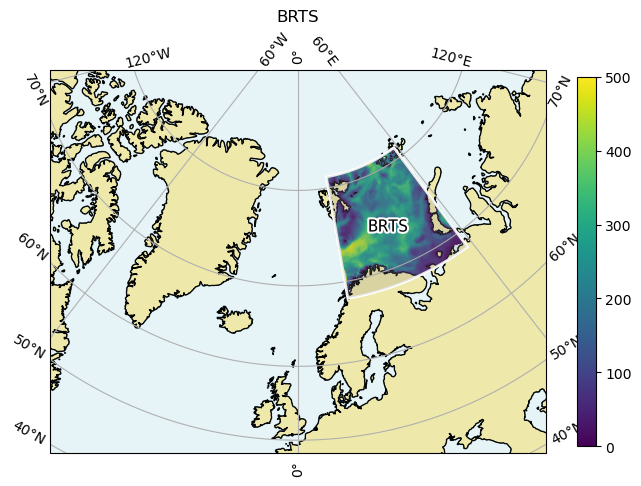

In [11]:
#-----------------------------------------------------------------
# Sample Use Case:
#
#   Retrieve subset of model variable
#
#      input: OMmask_boolean_TP2.pckl
#             
#-----------------------------------------------------------------

region = 'TP2a0.10'
outname = region[0:3]
DIR_CNFG=f"/root/projects/bioran_v2/NERSC-HYCOM-CICE_BIORANv2/{region}/topo" # where to find "regional.grid"

#-- load TP2 grid data

file_path = f"{DIR_CNFG}/regional.grid"
ab_grid = abfile.ABFileGrid(file_path,"r")
plon=ab_grid.read_field("plon")
plat=ab_grid.read_field("plat")

#-- load TP2 depth data (as an example of model variable)

file_path = f"{DIR_CNFG}/depth_TP2a0.10_02" # regional.depth
ab_dpth = abfile.ABFileBathy(file_path,"r",idm=ab_grid.idm,jdm=ab_grid.jdm)
depth=ab_dpth.read_field("depth")

#-- specify target region name

polyname = 'BRTS'

#-- load mask file

with open('./OMmask_boolean_'+outname+'.pckl', 'rb') as f:
    dict_mask = pickle.load(f)

#-- extract 2D mask for specific region

mask_region = dict_mask[polyname]

#-- extract model variable inside of the region. Note: extracted data are in 1D array

plon_subset = plon[mask_region]
plat_subset = plat[mask_region]
depth_subset = depth[mask_region]
vmin = 0.0
vmax = 500.0

#-- plot extracted variable

list_polyname = [polyname]
list_extent = (-55, 55, 48, 88)
projection = ccrs.LambertConformal(central_longitude=0, central_latitude=60)
loc_data = [plon_subset,plat_subset]
regions_title = f"{polyname}"
plot_regions(list_polyname,list_extent,projection,dict_regions,regions_title,loc_data,depth_subset,vmin,vmax)

In [12]:
#-----------------------------------------------------------------
# Sample Use Case:
#
#   Create boolean mask based on polygon definition file
#
#      input: validation_regions_ARCMFC.pckl
#     output: OMmask_boolean_TP2.pckl
#
#-----------------------------------------------------------------
isplot = False

#-- load region definition files

with open('./validation_regions_ARCMFC.pckl', 'rb') as f:
    dict_regions = pickle.load(f)

#-- create dictionary of boolean mask for each region
 
list_polyname = ['LFTB','ERSB','IBIB','CHBF','CACH','NRWB','LBRD','LPES','BRGS','BRTS','BFFB','KARA','GSIS','ARSB']

dict_mask = {}

for idx, polyname in enumerate(list_polyname):
    polygon,label_coord,long_name = polygon_from_dict(polyname, dict_regions)

    x = np.copy(plon)
    y = np.copy(plat)

    if polyname == 'ARSB':  # Amresia Basin needs special treatment to create proper mask
        x = np.where(x < 0, x + 360, x)
    
    # create boolean mask for polygon
    lon_flat = x.flatten()
    lat_flat = y.flatten()
    points = np.column_stack((lon_flat, lat_flat))
    mask_flat = np.array([polygon.contains(Point(lon, lat)) for lon, lat in points])
    mask_2d = mask_flat.reshape(plon.shape)

    dict_mask[polyname] = mask_2d

    #-- extract coordinates inside of the polygon
    
    plon_subset = plon[mask_2d] # extract data inside of Polygon
    plat_subset = plat[mask_2d] # extract data inside of Polygon
    
    #-- check Polygon mask

    if isplot:
        regions_title = f"{polyname}: {long_name}"
        list_extent = (-180, 180, 50, 90)
        projection = ccrs.NorthPolarStereo()
        loc_data = [plon_subset,plat_subset]
        plot_regions([polyname],list_extent,projection,dict_regions,regions_title,loc_data)

#-- save boolean mask file

outname = region[0:3]
with open('./OMmask_boolean_'+outname+'.pckl', 'wb') as f:
    pickle.dump(dict_mask, f)

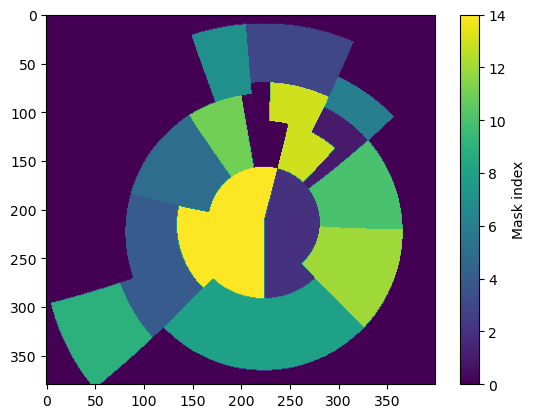

In [13]:
#-----------------------------------------------------------------
# Sample Use Case:
#
#   Create 2D mask dictionary file as make_OM_regional_masks.py
#
#      input: OMmask_boolean_TP2.pckl
#     output: OMmaskTP2.pckl
#
#-----------------------------------------------------------------

# load boolean mask file

with open('./OMmask_boolean_'+outname+'.pckl', 'rb') as f:
    dict_mask = pickle.load(f)

# create dictionary of 2D masks and mask index map (maskall)
maskall = np.zeros((plon.shape))

dict_mask2D = {}
for idx, key in enumerate(dict_mask):
    mask_2d = dict_mask[key]
    maskall[mask_2d] = idx + 1.0

    mask_region = np.zeros((plon.shape))
    mask_region[mask_2d] = 1.0
    dict_mask2D[key] = mask_region

# save 2D mask file [0 or 1]

with open('./OMmask'+outname+'.pckl', 'wb') as f:
    pickle.dump(dict_mask, f)

plt.imshow(maskall)
plt.colorbar(label="Mask index")
plt.show()

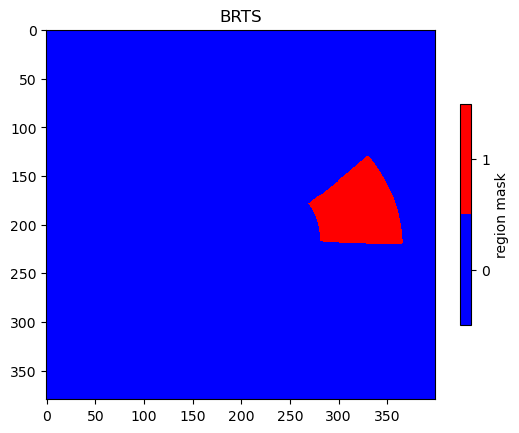

In [14]:
#-----------------------------------------------------------------
# Sample Use Case:
#
#   Retrieve specific 2D region mask [0 or 1]
#
#      input: OMmaskTP2.pckl
#
#-----------------------------------------------------------------

#-- specify target region name

key = 'BRTS'

#-- load mask file

with open('./OMmask'+outname+'.pckl', 'rb') as f:
    dict_mask2D = pickle.load(f)

#-- extract 2D mask for specific region

mask_region = dict_mask2D[key]

#-- plot region mask

from matplotlib.colors import ListedColormap
cmap = ListedColormap(["blue", "red"])
plt.imshow(mask_region, cmap=cmap, vmin=0, vmax=1)
cbar = plt.colorbar(label="region mask",shrink=0.6)
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(["0", "1"])
plt.title(key)
plt.show()

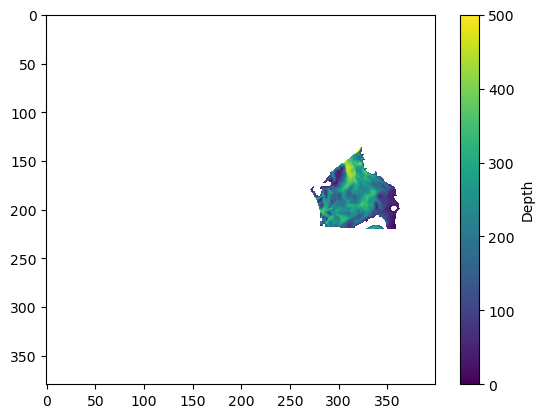

In [15]:
#-----------------------------------------------------------------
# Sample Use Case:
#
#   Retrieve subset of model variable using 2D mask
#
#      input: OMmaskTP2.pckl
#             
#-----------------------------------------------------------------

region = 'TP2a0.10'
DIR_CNFG=f"/root/projects/bioran_v2/NERSC-HYCOM-CICE_BIORANv2/{region}/topo" # where to find "regional.grid"

#-- load TP2 grid data

file_path = f"{DIR_CNFG}/regional.grid"
ab_grid = abfile.ABFileGrid(file_path,"r")
plon=ab_grid.read_field("plon")
plat=ab_grid.read_field("plat")

#-- load TP2 depth data (as an example of model variable)

file_path = f"{DIR_CNFG}/depth_TP2a0.10_02" # regional.depth
ab_dpth = abfile.ABFileBathy(file_path,"r",idm=ab_grid.idm,jdm=ab_grid.jdm)
depth=ab_dpth.read_field("depth")

#-- specify target region name

polyname = 'BRTS'

#-- load mask file

with open('./OMmask'+outname+'.pckl', 'rb') as f:
    dict_mask2D = pickle.load(f)

#-- extract 2D mask for specific region

mask2D = dict_mask2D[key]

#-- update masked array

depth.mask = np.logical_or(depth.mask, mask2D == 0)

#-- plot variable

plt.imshow(depth,vmin=0,vmax=500)
plt.colorbar(label="Depth")
plt.show()